In [ ]:
#prezentacja 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from scipy.stats import f_oneway, chi2_contingency
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings('ignore')
np.random.seed = 42

c:\Users\66891\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
df = pd.read_csv('lung_cancer_prediction_dataset.csv')
df.head()

,ID,Country,Population_Size,Age,Gender,Smoker,Years_of_Smoking,Cigarettes_per_Day,Passive_Smoker,Family_History,...,Air_Pollution_Exposure,Occupational_Exposure,Indoor_Pollution,Healthcare_Access,Early_Detection,Treatment_Type,Developed_or_Developing,Annual_Lung_Cancer_Deaths,Lung_Cancer_Prevalence_Rate,Mortality_Rate
0,0,China,1400,80,Male,Yes,30,29,No,No,...,Low,Yes,No,Poor,No,NaN,Developing,690000,2.44,0.0
1,1,Iran,84,53,Male,No,0,0,Yes,No,...,Low,Yes,No,Poor,No,NaN,Developing,27000,2.10,0.0
2,2,Mexico,128,47,Male,Yes,12,6,Yes,No,...,Medium,No,No,Poor,Yes,NaN,Developing,28000,1.11,0.0
3,3,Indonesia,273,39,Female,No,0,0,No,Yes,...,Low,No,No,Poor,No,NaN,Developing,40000,0.75,0.0
4,4,South Africa,59,44,Female,No,0,0,Yes,No,...,Medium,Yes,No,Poor,No,NaN,Developing,15000,2.44,0.0


In [4]:
df.columns


Index(['ID', 'Country', 'Population_Size', 'Age', 'Gender', 'Smoker',
       'Years_of_Smoking', 'Cigarettes_per_Day', 'Passive_Smoker',
       'Family_History', 'Lung_Cancer_Diagnosis', 'Cancer_Stage',
       'Survival_Years', 'Adenocarcinoma_Type', 'Air_Pollution_Exposure',
       'Occupational_Exposure', 'Indoor_Pollution', 'Healthcare_Access',
       'Early_Detection', 'Treatment_Type', 'Developed_or_Developing',
       'Annual_Lung_Cancer_Deaths', 'Lung_Cancer_Prevalence_Rate',
       'Mortality_Rate'],
      dtype='object')

Tabela korelacji:
                            Age  Years_of_Smoking  Cigarettes_per_Day  \
Age                    1.000000          0.002092            0.001196   
Years_of_Smoking       0.002092          1.000000            0.708114   
Cigarettes_per_Day     0.001196          0.708114            1.000000   
Passive_Smoker        -0.000087          0.003588            0.002164   
Family_History         0.002228         -0.001280           -0.001010   
Lung_Cancer_Diagnosis  0.001578          0.100779            0.109157   
Occupational_Exposure -0.001637         -0.000151            0.001458   
Indoor_Pollution       0.002284         -0.001969           -0.001013   

                       Passive_Smoker  Family_History  Lung_Cancer_Diagnosis  \
Age                         -0.000087        0.002228               0.001578   
Years_of_Smoking             0.003588       -0.001280               0.100779   
Cigarettes_per_Day           0.002164       -0.001010               0.109157   
Pass

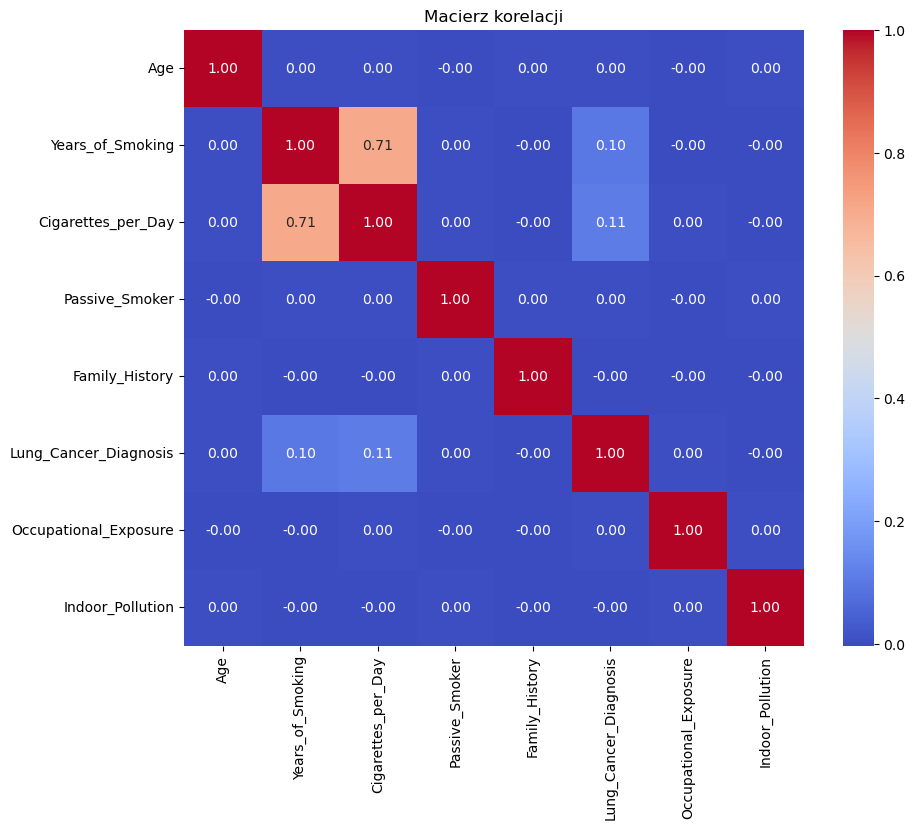

In [5]:
df = df[['Age', 'Gender', 'Years_of_Smoking', 'Cigarettes_per_Day', 'Passive_Smoker',
         'Family_History', 'Lung_Cancer_Diagnosis', 'Air_Pollution_Exposure',
         'Occupational_Exposure', 'Indoor_Pollution', 'Healthcare_Access']]

# Zamiana 'yes'/'no' na 1/0
df.replace({'Yes': 1, 'No': 0}, inplace=True)

# Tworzenie tabeli korelacji
correlation_matrix = df.corr(numeric_only=True)
print("Tabela korelacji:")
print(correlation_matrix)

# Wizualizacja korelacji
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Macierz korelacji')
plt.show()

# Wykresy punktowe dla każdej pary kolumn
#sns.pairplot(df)
#plt.show()


In [6]:
df.columns

Index(['Age', 'Gender', 'Years_of_Smoking', 'Cigarettes_per_Day',
       'Passive_Smoker', 'Family_History', 'Lung_Cancer_Diagnosis',
       'Air_Pollution_Exposure', 'Occupational_Exposure', 'Indoor_Pollution',
       'Healthcare_Access'],
      dtype='object')

In [7]:
def validate_and_clean_data(df):
    invalid_rows = []
    reasons = []
    
    # Sprawdzenie 1: Years_of_Smoking nie może być większe niż Age
    mask = df['Years_of_Smoking'] > df['Age']
    invalid_rows.extend(df[mask].index.tolist())
    reasons.extend(["Years_of_Smoking > Age"] * mask.sum())
    
    # Sprawdzenie 2: Jeśli Years_of_Smoking == 0, to Cigarettes_per_Day powinno być 0
    mask = (df['Years_of_Smoking'] == 0) & (df['Cigarettes_per_Day'] > 0)
    invalid_rows.extend(df[mask].index.tolist())
    reasons.extend(["Cigarettes_per_Day > 0 despite Years_of_Smoking == 0"] * mask.sum())
    
    # Tworzenie DataFrame z błędnymi rekordami
    invalid_df = df.loc[invalid_rows].copy()
    invalid_df['Reason'] = reasons
    
    # Usuwanie błędnych rekordów
    df_cleaned = df.drop(index=invalid_rows)
    
    # Sprawdzenie liczby wierszy z NaN/null
    missing_values_rows = df_cleaned.isnull().any(axis=1).sum()
    
    return invalid_df, df_cleaned, missing_values_rows


invalid_rows_df, cleaned_df, missing_values_count = validate_and_clean_data(df)
print("Invalid records:")
print(invalid_rows_df)
print(f"Number of rows with missing values after cleanup: {missing_values_count}")


Invalid records:
        Age  Gender  Years_of_Smoking  Cigarettes_per_Day  Passive_Smoker  \
8        32    Male                37                  29               0   
34       24    Male                28                  17               0   
40       20    Male                39                  20               0   
67       24  Female                30                  13               1   
74       29    Male                36                  17               1   
...     ...     ...               ...                 ...             ...   
220507   29    Male                39                  25               0   
220520   25    Male                36                  26               0   
220567   32  Female                40                  11               0   
220594   25  Female                37                   9               1   
220626   36  Female                40                  26               1   

        Family_History  Lung_Cancer_Diagnosis Air_Pollutio

In [8]:
mask = (df['Years_of_Smoking'] == 0) & (df['Cigarettes_per_Day'] > 0)
print(f"Liczba rekordów niespełniających warunku 'Years_of_Smoking == 0' -> 'Cigarettes_per_Day == 0': {mask.sum()}")


Liczba rekordów niespełniających warunku 'Years_of_Smoking == 0' -> 'Cigarettes_per_Day == 0': 0


In [9]:
df = df.drop(index=invalid_rows_df.index)


In [10]:
df.describe()

,Age,Years_of_Smoking,Cigarettes_per_Day,Passive_Smoker,Family_History,Lung_Cancer_Diagnosis,Occupational_Exposure,Indoor_Pollution
count,213715.000000,213715.000000,213715.000000,213715.000000,213715.000000,213715.000000,213715.000000,213715.000000
mean,53.366263,7.349082,6.667894,0.298926,0.148885,0.039599,0.301481,0.231313
std,18.763963,11.645881,9.678664,0.457788,0.355976,0.195017,0.458902,0.421673
min,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,54.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,70.000000,13.000000,13.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,85.000000,40.000000,30.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
missing_from_describe = set(df.columns) - set(df.describe().columns)
print("Kolumny nieuwzględnione w describe():", missing_from_describe)


Kolumny nieuwzględnione w describe(): {'Air_Pollution_Exposure', 'Healthcare_Access', 'Gender'}


In [12]:
for col in ['Healthcare_Access', 'Gender', 'Air_Pollution_Exposure']:
    print(f"\n{col} - unikalne wartości:")
    print(df[col].value_counts())



Healthcare_Access - unikalne wartości:
Healthcare_Access
Poor    171017
Good     42698
Name: count, dtype: int64

Gender - unikalne wartości:
Gender
Female    108305
Male      105410
Name: count, dtype: int64

Air_Pollution_Exposure - unikalne wartości:
Air_Pollution_Exposure
Medium    106688
Low        53625
High       53402
Name: count, dtype: int64


In [13]:
# Zamiana płci na wartości binarne
df['Gender'] = df['Gender'].map({'Female': 0, 'Male': 1})

# Zamiana poziomu zanieczyszczenia powietrza na liczby porządkowe
df['Air_Pollution_Exposure'] = df['Air_Pollution_Exposure'].map({'Low': 0, 'Medium': 1, 'High': 2})

# Zamiana dostępu do opieki zdrowotnej na wartości binarne
df['Healthcare_Access'] = df['Healthcare_Access'].map({'Poor': 0, 'Good': 1})

# Sprawdzenie, czy konwersja się powiodła
print(df[['Gender', 'Air_Pollution_Exposure', 'Healthcare_Access']].head())


   Gender  Air_Pollution_Exposure  Healthcare_Access
0       1                       0                  0
1       1                       0                  0
2       1                       1                  0
3       0                       0                  0
4       0                       1                  0


Rozkład klasyfikacji:
Lung_Cancer_Diagnosis
0    0.960401
1    0.039599
Name: proportion, dtype: float64

Korelacje cech z diagnozą raka płuc:
Lung_Cancer_Diagnosis     1.000000
Cigarettes_per_Day        0.108905
Years_of_Smoking          0.100116
Gender                    0.039200
Age                       0.009179
Passive_Smoker            0.003259
Occupational_Exposure     0.002382
Healthcare_Access         0.001931
Air_Pollution_Exposure    0.001622
Family_History           -0.001753
Indoor_Pollution         -0.001969
Name: Lung_Cancer_Diagnosis, dtype: float64

Air_Pollution_Exposure: 3 unikalnych wartości
Air_Pollution_Exposure
1    106688
0     53625
2     53402
Name: count, dtype: int64

Healthcare_Access: 2 unikalnych wartości
Healthcare_Access
0    171017
1     42698
Name: count, dtype: int64

Gender: 2 unikalnych wartości
Gender
0    108305
1    105410
Name: count, dtype: int64


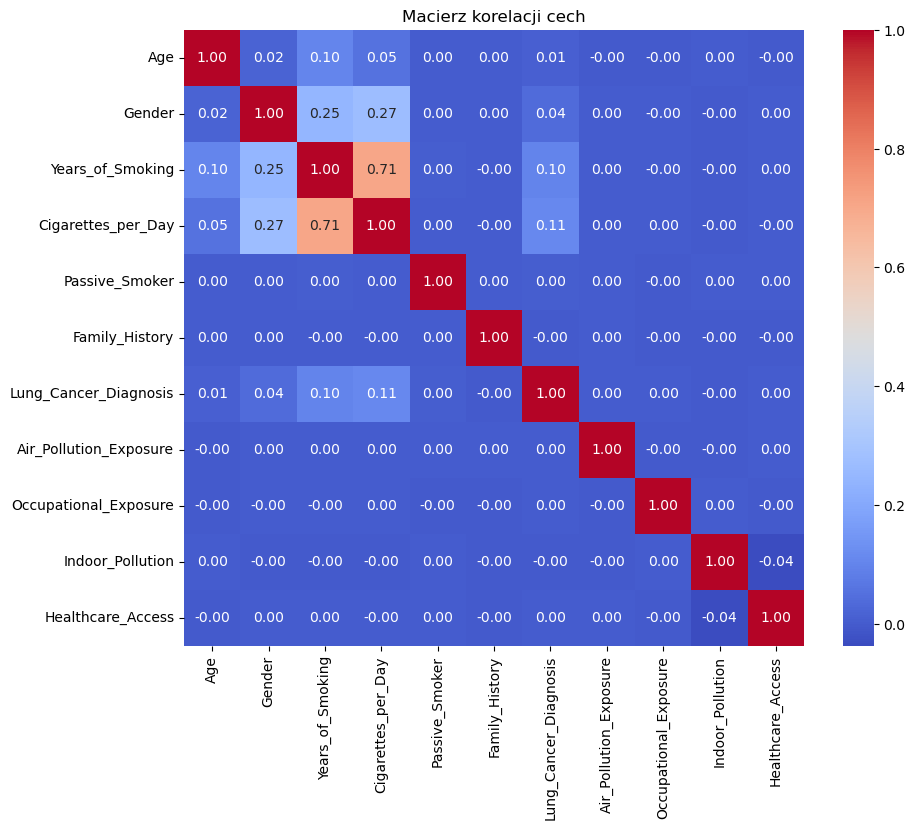

In [14]:
# 1. Sprawdzenie rozkładu zmiennej celu
print("Rozkład klasyfikacji:")
print(df['Lung_Cancer_Diagnosis'].value_counts(normalize=True))

# 2. Korelacja cech liczbowych z diagnozą raka
correlations = df.corr()['Lung_Cancer_Diagnosis'].sort_values(ascending=False)
print("\nKorelacje cech z diagnozą raka płuc:")
print(correlations)

# 3. Sprawdzenie unikalnych wartości dla potencjalnie kategorycznych kolumn
for col in missing_from_describe:
    print(f"\n{col}: {df[col].nunique()} unikalnych wartości")
    print(df[col].value_counts())

# 4. Wizualizacja macierzy korelacji
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Macierz korelacji cech")
plt.show()


In [15]:
print(df['Air_Pollution_Exposure'].value_counts())


Air_Pollution_Exposure
1    106688
0     53625
2     53402
Name: count, dtype: int64


In [16]:
# Podział na cechy i target 
X = df.drop('Lung_Cancer_Diagnosis', axis=1)
y = df['Lung_Cancer_Diagnosis']

# Selekcja cech za pomocą chi-kwadrat
selector = SelectKBest(score_func=chi2, k=5)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print("Wybrane cechy (chi-kwadrat):", selected_features.tolist())

Wybrane cechy (chi-kwadrat): ['Age', 'Gender', 'Years_of_Smoking', 'Cigarettes_per_Day', 'Passive_Smoker']


In [17]:
# Trenowanie modelu
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

# Ważność cech
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Ranking cech (Random Forest):\n", feature_importance)

Ranking cech (Random Forest):
                   Feature  Importance
0                     Age    0.349146
2        Years_of_Smoking    0.264178
3      Cigarettes_per_Day    0.232209
6  Air_Pollution_Exposure    0.041681
7   Occupational_Exposure    0.022660
8        Indoor_Pollution    0.019193
1                  Gender    0.018360
4          Passive_Smoker    0.018230
5          Family_History    0.017639
9       Healthcare_Access    0.016705


Korelacja Total_Exposure z Lung_Cancer_Diagnosis: 0.001


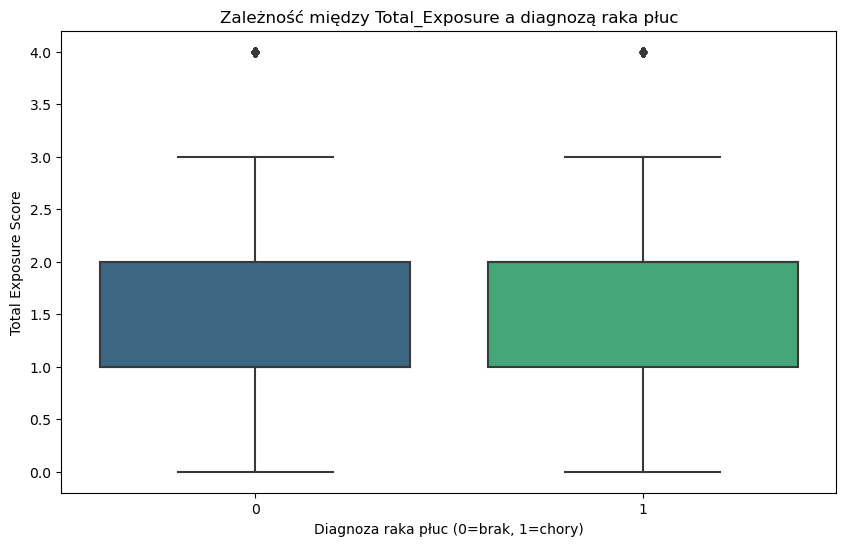

In [18]:
final_selected_features = ['Age', 'Years_of_Smoking', 'Cigarettes_per_Day']

# 1. Tworzenie nowej cechy
df['Total_Exposure'] = (
    df['Indoor_Pollution'] + 
    df['Air_Pollution_Exposure'] + 
    df['Occupational_Exposure']
)

# 2. Obliczenie korelacji
correlation = df[['Total_Exposure', 'Lung_Cancer_Diagnosis']].corr().iloc[0, 1]
print(f"Korelacja Total_Exposure z Lung_Cancer_Diagnosis: {correlation:.3f}")

# 3. Wizualizacja
plt.figure(figsize=(10, 6))

sns.boxplot(
    x='Lung_Cancer_Diagnosis', 
    y='Total_Exposure', 
    data=df,
    palette="viridis"
)

plt.title('Zależność między Total_Exposure a diagnozą raka płuc')
plt.xlabel('Diagnoza raka płuc (0=brak, 1=chory)')
plt.ylabel('Total Exposure Score')
plt.show()

In [19]:
df.columns

Index(['Age', 'Gender', 'Years_of_Smoking', 'Cigarettes_per_Day',
       'Passive_Smoker', 'Family_History', 'Lung_Cancer_Diagnosis',
       'Air_Pollution_Exposure', 'Occupational_Exposure', 'Indoor_Pollution',
       'Healthcare_Access', 'Total_Exposure'],
      dtype='object')

Korelacja Pearsona: 0.090
Korelacja Spearmana: 0.120
Test chi-kwadrat - p-wartość: 0.000
AUC: 0.656


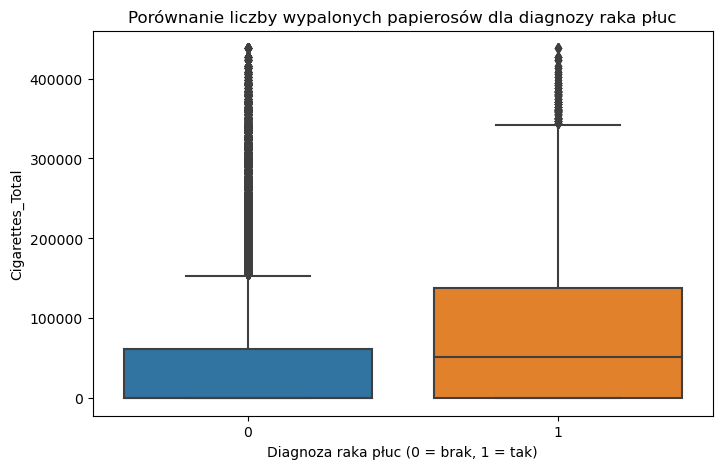

In [20]:
from sklearn.metrics import roc_auc_score

df["Cigarettes_Total"] = df["Years_of_Smoking"] * df["Cigarettes_per_Day"] * 365

# Obliczenie korelacji Pearsona i Spearmana
corr_pearson = df[["Cigarettes_Total", "Lung_Cancer_Diagnosis"]].corr().iloc[0, 1]
corr_spearman = df[["Cigarettes_Total", "Lung_Cancer_Diagnosis"]].corr(method="spearman").iloc[0, 1]

# Test chi-kwadrat
df["Cigarettes_High"] = df["Cigarettes_Total"] > df["Cigarettes_Total"].median()
contingency_table = pd.crosstab(df["Cigarettes_High"], df["Lung_Cancer_Diagnosis"])
chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)

# AUC
auc_score = roc_auc_score(df["Lung_Cancer_Diagnosis"], df["Cigarettes_Total"])

# Prezentacja wyników
print(f"Korelacja Pearsona: {corr_pearson:.3f}")
print(f"Korelacja Spearmana: {corr_spearman:.3f}")
print(f"Test chi-kwadrat - p-wartość: {p_value:.3f}")
print(f"AUC: {auc_score:.3f}")

# Wizualizacja korelacji
plt.figure(figsize=(8, 5))
sns.boxplot(x=df["Lung_Cancer_Diagnosis"], y=df["Cigarettes_Total"])
plt.title("Porównanie liczby wypalonych papierosów dla diagnozy raka płuc")
plt.xlabel("Diagnoza raka płuc (0 = brak, 1 = tak)")
plt.ylabel("Cigarettes_Total")
plt.show()

Analiza cechy: Years_of_Smoking
Korelacja Pearsona: 0.100
Korelacja Spearmana: 0.120
Test chi-kwadrat - p-wartość: 0.000
AUC: 0.655



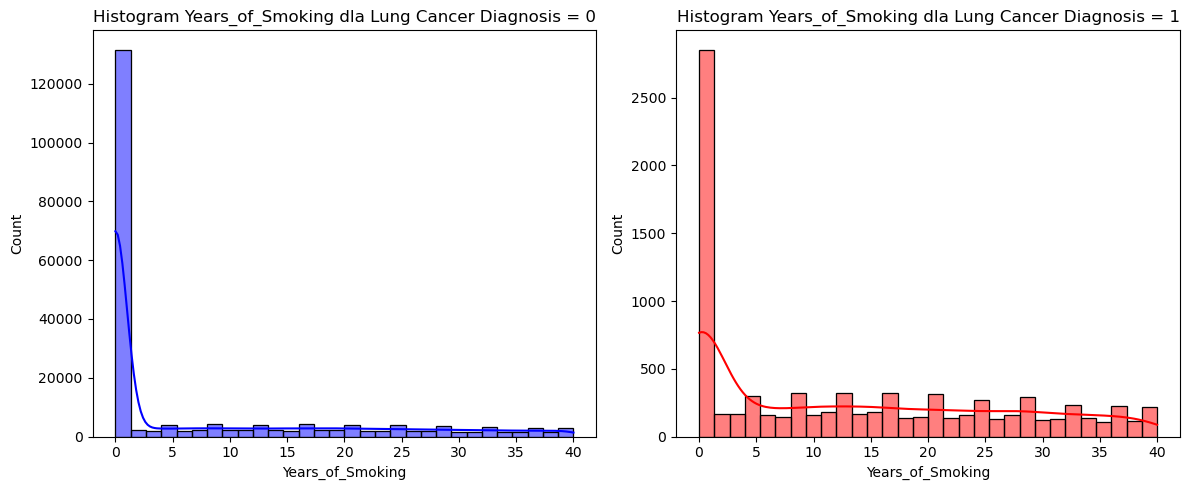

Analiza cechy: Cigarettes_per_Day
Korelacja Pearsona: 0.109
Korelacja Spearmana: 0.120
Test chi-kwadrat - p-wartość: 0.000
AUC: 0.655



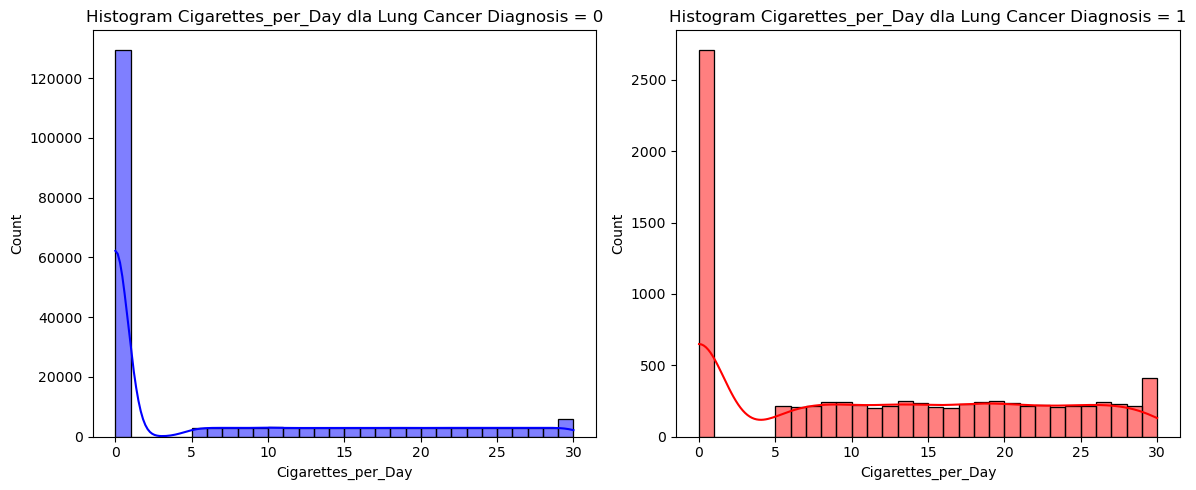

Analiza cechy: Total_Exposure
Korelacja Pearsona: 0.001
Korelacja Spearmana: 0.002
Test chi-kwadrat - p-wartość: 0.580
AUC: 0.502



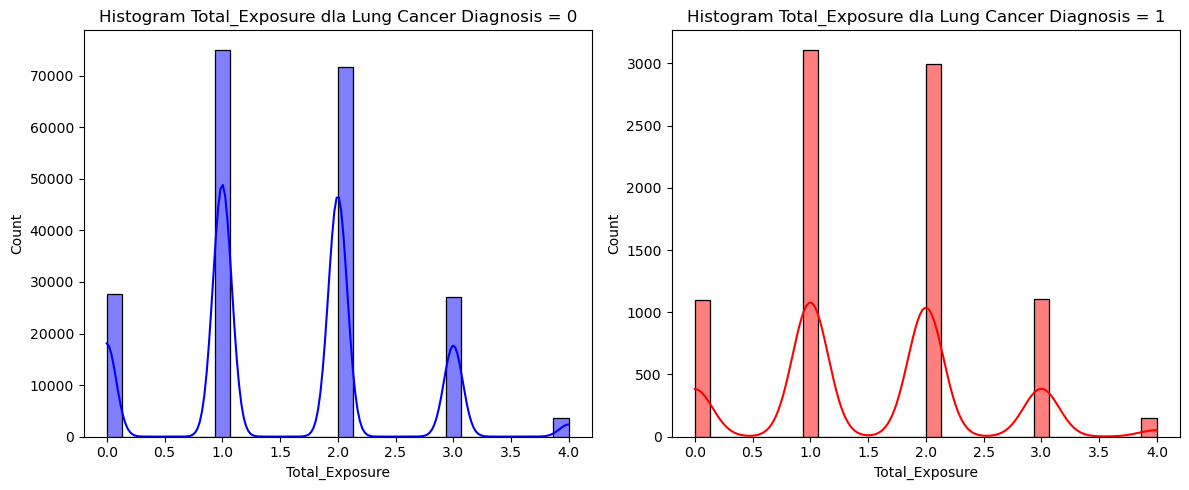

Analiza cechy: Cigarettes_Total
Korelacja Pearsona: 0.090
Korelacja Spearmana: 0.120
Test chi-kwadrat - p-wartość: 0.000
AUC: 0.656



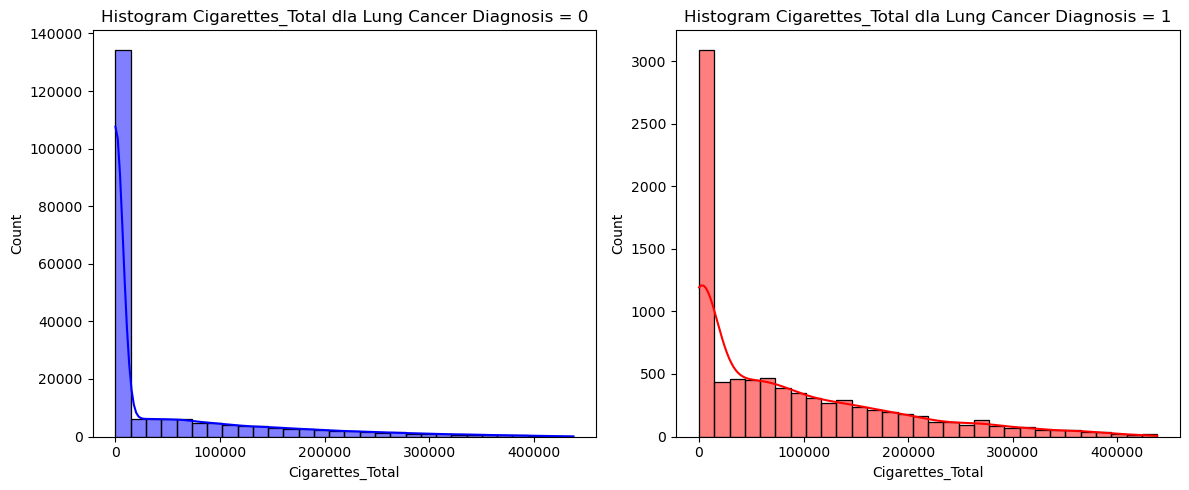

Analiza cechy: Age_Smoking_Effect
Korelacja Pearsona: 0.093
Korelacja Spearmana: 0.120
Test chi-kwadrat - p-wartość: 0.000
AUC: 0.656



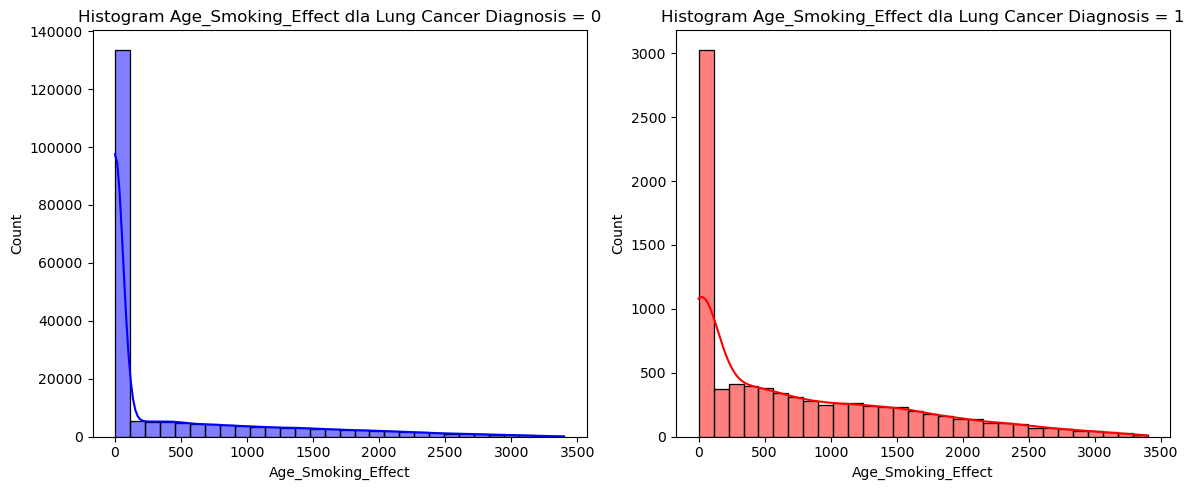

In [21]:
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler

#df["Smoking_Intensity"] = df["Years_of_Smoking"] * df["Cigarettes_per_Day"]
df["Age_Smoking_Effect"] = df["Age"] * df["Years_of_Smoking"]
#df["Pollution_Exposure_Total"] = df[["Air_Pollution_Exposure", "Occupational_Exposure", "Indoor_Pollution"]].sum(axis=1)

# Lista nowych cech do analizy
new_features = ['Years_of_Smoking', 'Cigarettes_per_Day',
        'Total_Exposure',"Cigarettes_Total", "Age_Smoking_Effect"]

for feature in new_features:
    print(f"Analiza cechy: {feature}")
    
    # Korelacja Pearsona i Spearmana
    corr_pearson = df[[feature, "Lung_Cancer_Diagnosis"]].corr().iloc[0, 1]
    corr_spearman = df[[feature, "Lung_Cancer_Diagnosis"]].corr(method="spearman").iloc[0, 1]
    
    # Test chi-kwadrat
    df[feature + "_High"] = df[feature] > df[feature].median()
    contingency_table = pd.crosstab(df[feature + "_High"], df["Lung_Cancer_Diagnosis"])
    chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)
    
    # AUC
    auc_score = roc_auc_score(df["Lung_Cancer_Diagnosis"], df[feature])
    
    # Prezentacja wyników
    print(f"Korelacja Pearsona: {corr_pearson:.3f}")
    print(f"Korelacja Spearmana: {corr_spearman:.3f}")
    print(f"Test chi-kwadrat - p-wartość: {p_value:.3f}")
    print(f"AUC: {auc_score:.3f}\n")
    
    # Wizualizacja korelacji
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(df[df["Lung_Cancer_Diagnosis"] == 0][feature], bins=30, kde=True, color='blue')
    plt.title(f"Histogram {feature} dla Lung Cancer Diagnosis = 0")
    plt.xlabel(feature)
    
    plt.subplot(1, 2, 2)
    sns.histplot(df[df["Lung_Cancer_Diagnosis"] == 1][feature], bins=30, kde=True, color='red')
    plt.title(f"Histogram {feature} dla Lung Cancer Diagnosis = 1")
    plt.xlabel(feature)
    
    plt.tight_layout()
    plt.show()


In [22]:
from scipy.stats import pearsonr, spearmanr, chi2_contingency

df["Smoking_Burden"] = (df["Cigarettes_Total"] + 1000 * df["Passive_Smoker"]) * (1 + df["Air_Pollution_Exposure"] + df["Indoor_Pollution"])
df["Exposure_Index"] = (df["Total_Exposure"] + df["Occupational_Exposure"] + df["Indoor_Pollution"]) * (1 + 0.5 * df["Years_of_Smoking"])
df["Health_Risk_Score"] = (df["Age"] + 5 * df["Family_History"]) * (1 - 0.2 * df["Healthcare_Access"])

# Lista nowych zmiennych do analizy
new_features = ["Smoking_Burden", "Exposure_Index", "Health_Risk_Score"]

# Testy korelacji i predykcyjności
results = []
for feature in new_features:
    pearson_corr, _ = pearsonr(df[feature], df["Lung_Cancer_Diagnosis"])
    spearman_corr, _ = spearmanr(df[feature], df["Lung_Cancer_Diagnosis"])
    auc = roc_auc_score(df["Lung_Cancer_Diagnosis"], df[feature])
    
    # Test chi-kwadrat (binarne podzielenie zmiennej)
    median_val = df[feature].median()
    df[feature + "_High"] = df[feature] > median_val
    contingency_table = pd.crosstab(df[feature + "_High"], df["Lung_Cancer_Diagnosis"])
    chi2, chi_p, _, _ = chi2_contingency(contingency_table)
    
    results.append({
        "Feature": feature,
        "Pearson Correlation": pearson_corr,
        "Spearman Correlation": spearman_corr,
        "AUC": auc,
        "Chi-Square p-value": chi_p
    })

# Tworzymy DataFrame z wynikami
results_df = pd.DataFrame(results)
results_df

,Feature,Pearson Correlation,Spearman Correlation,AUC,Chi-Square p-value
0,Smoking_Burden,0.083766,0.109567,0.655317,0.000000
1,Exposure_Index,0.075547,0.077277,0.613664,0.000000
2,Health_Risk_Score,0.008257,0.008389,0.512418,0.001768


In [23]:
df.columns

Index(['Age', 'Gender', 'Years_of_Smoking', 'Cigarettes_per_Day',
       'Passive_Smoker', 'Family_History', 'Lung_Cancer_Diagnosis',
       'Air_Pollution_Exposure', 'Occupational_Exposure', 'Indoor_Pollution',
       'Healthcare_Access', 'Total_Exposure', 'Cigarettes_Total',
       'Cigarettes_High', 'Age_Smoking_Effect', 'Years_of_Smoking_High',
       'Cigarettes_per_Day_High', 'Total_Exposure_High',
       'Cigarettes_Total_High', 'Age_Smoking_Effect_High', 'Smoking_Burden',
       'Exposure_Index', 'Health_Risk_Score', 'Smoking_Burden_High',
       'Exposure_Index_High', 'Health_Risk_Score_High'],
      dtype='object')

In [24]:
df = df.loc[:, ~df.columns.str.endswith('_High')]

In [25]:
df.columns

Index(['Age', 'Gender', 'Years_of_Smoking', 'Cigarettes_per_Day',
       'Passive_Smoker', 'Family_History', 'Lung_Cancer_Diagnosis',
       'Air_Pollution_Exposure', 'Occupational_Exposure', 'Indoor_Pollution',
       'Healthcare_Access', 'Total_Exposure', 'Cigarettes_Total',
       'Age_Smoking_Effect', 'Smoking_Burden', 'Exposure_Index',
       'Health_Risk_Score'],
      dtype='object')

In [26]:
df['Gender_Female'] = (df['Gender'] == 0).astype(int)
df['Gender_Male'] = (df['Gender'] == 1).astype(int)


df = df.drop(columns=['Gender'])

In [27]:
df.columns


Index(['Age', 'Years_of_Smoking', 'Cigarettes_per_Day', 'Passive_Smoker',
       'Family_History', 'Lung_Cancer_Diagnosis', 'Air_Pollution_Exposure',
       'Occupational_Exposure', 'Indoor_Pollution', 'Healthcare_Access',
       'Total_Exposure', 'Cigarettes_Total', 'Age_Smoking_Effect',
       'Smoking_Burden', 'Exposure_Index', 'Health_Risk_Score',
       'Gender_Female', 'Gender_Male'],
      dtype='object')

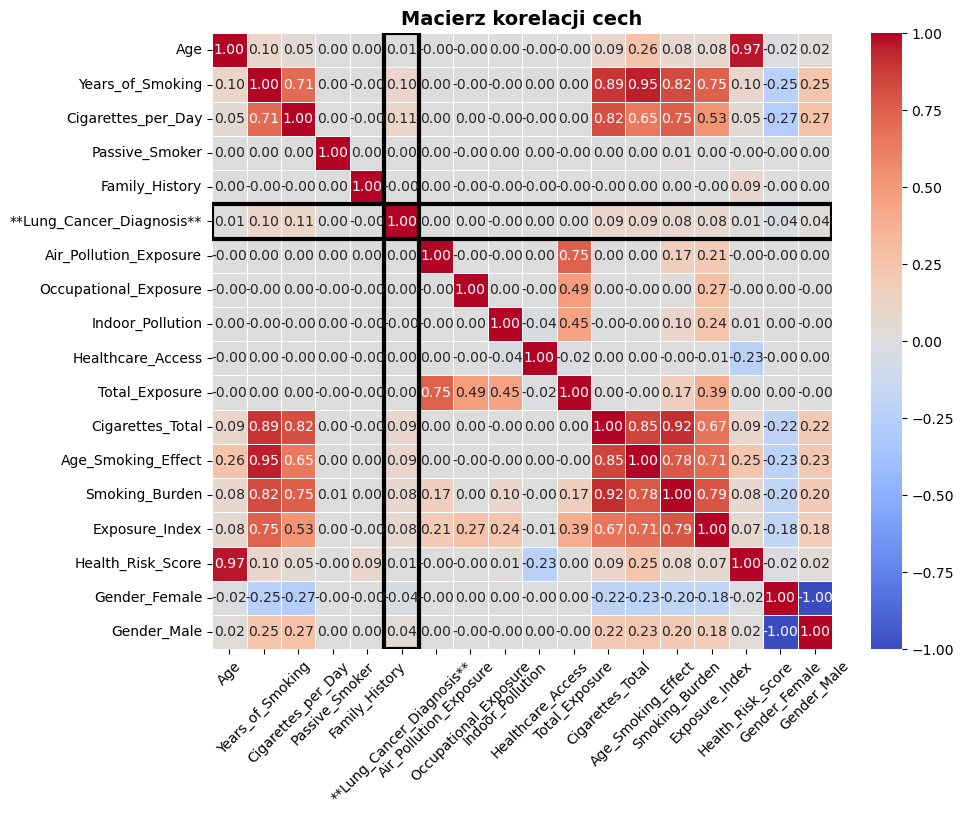


Korelacje cech z diagnozą raka płuc:
Lung_Cancer_Diagnosis     1.000000
Cigarettes_per_Day        0.108905
Years_of_Smoking          0.100116
Age_Smoking_Effect        0.092719
Cigarettes_Total          0.089925
Smoking_Burden            0.083766
Exposure_Index            0.075547
Gender_Male               0.039200
Age                       0.009179
Health_Risk_Score         0.008257
Passive_Smoker            0.003259
Occupational_Exposure     0.002382
Healthcare_Access         0.001931
Air_Pollution_Exposure    0.001622
Total_Exposure            0.001497
Family_History           -0.001753
Indoor_Pollution         -0.001969
Gender_Female            -0.039200
Name: Lung_Cancer_Diagnosis, dtype: float64


In [28]:
plt.figure(figsize=(10, 8))

# Tworzenie macierzy korelacji
corr_matrix = df.corr()

# Rysowanie heatmapy z dodatkową warstwą dla wyróżnienia
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Podkreślenie wiersza i kolumny 'Lung_Cancer_Diagnosis'
col_index = list(corr_matrix.columns).index('Lung_Cancer_Diagnosis')

# Obrysowanie wybranej kolumny i wiersza grubszą linią
plt.gca().add_patch(plt.Rectangle((col_index, 0), 1, len(corr_matrix), 
                                  fill=False, edgecolor='black', lw=3))

plt.gca().add_patch(plt.Rectangle((0, col_index), len(corr_matrix), 1, 
                                  fill=False, edgecolor='black', lw=3))

# Powiększenie etykiety 'Lung_Cancer_Diagnosis'
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.gca().set_xticklabels(
    [f"**{col}**" if col == "Lung_Cancer_Diagnosis" else col for col in corr_matrix.columns]
)
plt.gca().set_yticklabels(
    [f"**{col}**" if col == "Lung_Cancer_Diagnosis" else col for col in corr_matrix.columns]
)

plt.title("Macierz korelacji cech", fontsize=14, fontweight="bold")
plt.show()

# 2. Korelacja cech liczbowych z diagnozą raka
correlations = df.corr()['Lung_Cancer_Diagnosis'].sort_values(ascending=False)
print("\nKorelacje cech z diagnozą raka płuc:")
print(correlations)

In [29]:
# Trenowanie modelu
X = df.drop('Lung_Cancer_Diagnosis', axis=1)
y = df['Lung_Cancer_Diagnosis']
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

# Ważność cech
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Ranking cech (Random Forest):\n", feature_importance)

Ranking cech (Random Forest):
                    Feature  Importance
11      Age_Smoking_Effect    0.141781
12          Smoking_Burden    0.133500
14       Health_Risk_Score    0.130297
0                      Age    0.120431
10        Cigarettes_Total    0.116402
2       Cigarettes_per_Day    0.085729
13          Exposure_Index    0.073004
1         Years_of_Smoking    0.064108
3           Passive_Smoker    0.019019
9           Total_Exposure    0.017224
5   Air_Pollution_Exposure    0.015864
15           Gender_Female    0.015505
4           Family_History    0.015404
16             Gender_Male    0.015350
8        Healthcare_Access    0.013935
6    Occupational_Exposure    0.011704
7         Indoor_Pollution    0.010744


In [33]:
df.to_csv('learning_set.csv', index=False)
